### У нас есть данные АА-теста с '2022-11-25' по '2022-12-01'.
### Нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [5]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats
from tqdm import tqdm

In [6]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [7]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-11-25' and toDate(time) <= '2022-12-01' 
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
df=ph.read_clickhouse(q, connection=connection)
df.head()   

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


### Напишем функцию для запуска 10 000 симуляций А/А тестов, создания подвыборки из 500 пользователей, запуска t теста и вывода гистограммы.

<AxesSubplot:>

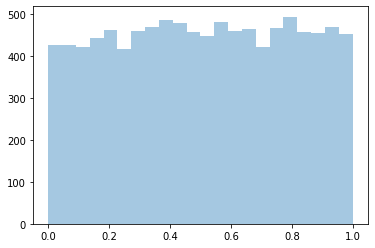

In [31]:
p=[]
for i in range(10000):
    pvalue=stats.ttest_ind(df[df.exp_group == 2].ctr.sample(n=500, replace = False),
                df[df.exp_group == 3].ctr.sample(n=500, replace = False),
                equal_var=False).pvalue
    p.append(pvalue)
sns.distplot(p,kde = False)
# 1. Создаем пустой список; 
# 2. Создаем функция с указанием числа симуляций;
# 3. Считаем t-тест с подвыборкой 500 в экспериментальных группах 2 и 3;
# 4. Добавляем полученные значения в список;
# 5. Рисуем гистограмму

In [32]:
# Напишем лямбда-функцию для подсчета процентного количества p-values оказался меньше либо равен 0.05

sum(map(lambda x : x<= 0.05, p))/len(p)*100

4.68

## Вывод:
### Так как расчет количество p-value<0.05 равно около 5% и график распределения близок к нормальному, то можно сделать вывод, что система сплитования работает корректно.